In [11]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem
from model import NestedUNet
from model import UNet

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from torchinfo import summary

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# 1. Preparation

## 1.1 DataModule

In [3]:
batch_size = 8
num_workers = 4

In [4]:
road_data = RoadSatelliteModule()

In [5]:
X, y = next(iter(road_data.val_dataloader()))

## 1.2 Inspect Data

In [6]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

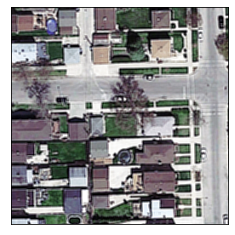

In [7]:
show_image(X[0])

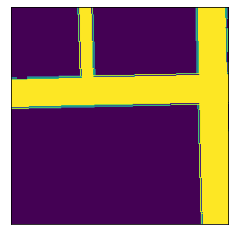

In [8]:
show_image(y[0])

# 2. Define Model / System

In [12]:
model = UNet(1, 3).cuda()

In [13]:
summary(model, input_size=(8, 3, 400, 400))

Layer (type:depth-idx)                                  Output Shape              Param #
UNet                                                    --                        --
├─VGGSpatialBlock: 1-1                                  [8, 16, 400, 400]         --
│    └─Conv2d: 2-1                                      [8, 16, 400, 400]         448
│    └─BatchNorm2d: 2-2                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-3                                        [8, 16, 400, 400]         --
│    └─ResSDNLayer: 2-4                                 [8, 16, 400, 400]         --
│    │    └─Conv2d: 3-1                                 [8, 16, 400, 400]         2,320
│    │    └─SDNLayer: 3-2                               [8, 32, 400, 400]         15,536
│    └─BatchNorm2d: 2-5                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-6                                        [8, 16, 400, 400]         --
├─MaxPool2d: 1-2                                    

In [14]:
X, y = next(iter(road_data.train_dataloader()))

In [15]:
X.shape

torch.Size([8, 3, 256, 256])

In [16]:
y_pred = model(X[:2].float().cuda())

In [17]:
y_pred.shape

torch.Size([2, 1, 256, 256])

In [18]:
system = SemanticSegmentationSystem(model, road_data)

# 4. Training

In [19]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=20,
   verbose=2,
   mode='max'
)

In [20]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=-1,
    auto_select_gpus=True,
    #auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [21]:
#trainer.tune(system)

In [ ]:
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | UNet     | 5.2 M 
1 | dice_loss | DiceLoss | 0     
---------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.634    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_metric improved. New best score: 0.217


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.047 >= min_delta = 0.0. New best score: 0.264


Epoch     2: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch     3: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.372 >= min_delta = 0.0. New best score: 0.636


Epoch     4: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.125 >= min_delta = 0.0. New best score: 0.761


Epoch     5: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Epoch     6: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Epoch     7: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Epoch     8: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch     9: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    10: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.014 >= min_delta = 0.0. New best score: 0.775


Epoch    11: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.021 >= min_delta = 0.0. New best score: 0.796


Epoch    12: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    13: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.051 >= min_delta = 0.0. New best score: 0.847


Epoch    14: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch    15: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.021 >= min_delta = 0.0. New best score: 0.869


Epoch    16: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch    17: adjusting learning rate of group 0 to 7.2727e-04.


Validating: 0it [00:00, ?it/s]

Epoch    18: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Epoch    19: adjusting learning rate of group 0 to 5.7864e-04.


Validating: 0it [00:00, ?it/s]

Epoch    20: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Epoch    21: adjusting learning rate of group 0 to 4.2236e-04.


Validating: 0it [00:00, ?it/s]

Epoch    22: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.011 >= min_delta = 0.0. New best score: 0.880


Epoch    23: adjusting learning rate of group 0 to 2.7373e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.012 >= min_delta = 0.0. New best score: 0.891


Epoch    24: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.012 >= min_delta = 0.0. New best score: 0.903


Epoch    25: adjusting learning rate of group 0 to 1.4730e-04.


Validating: 0it [00:00, ?it/s]

Epoch    26: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch    27: adjusting learning rate of group 0 to 5.5442e-05.


Validating: 0it [00:00, ?it/s]

Epoch    28: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    29: adjusting learning rate of group 0 to 7.1497e-06.


Validating: 0it [00:00, ?it/s]

Epoch    30: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    31: adjusting learning rate of group 0 to 9.9846e-04.


Validating: 0it [00:00, ?it/s]

Epoch    32: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    33: adjusting learning rate of group 0 to 9.8620e-04.


Validating: 0it [00:00, ?it/s]

Epoch    34: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    35: adjusting learning rate of group 0 to 9.6198e-04.


Validating: 0it [00:00, ?it/s]

Epoch    36: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Epoch    37: adjusting learning rate of group 0 to 9.2639e-04.


Validating: 0it [00:00, ?it/s]

Epoch    38: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch    39: adjusting learning rate of group 0 to 8.8032e-04.


Validating: 0it [00:00, ?it/s]

Epoch    40: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Epoch    41: adjusting learning rate of group 0 to 8.2490e-04.


Validating: 0it [00:00, ?it/s]

Epoch    42: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch    43: adjusting learning rate of group 0 to 7.6149e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.911


Epoch    44: adjusting learning rate of group 0 to 7.2727e-04.


Validating: 0it [00:00, ?it/s]

Epoch    45: adjusting learning rate of group 0 to 6.9165e-04.


Validating: 0it [00:00, ?it/s]

Epoch    46: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Epoch    47: adjusting learning rate of group 0 to 6.1711e-04.


Validating: 0it [00:00, ?it/s]

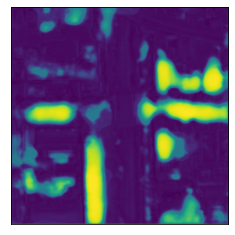

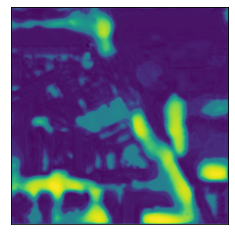

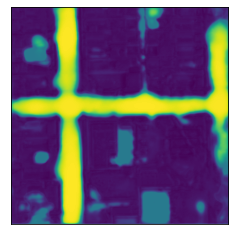

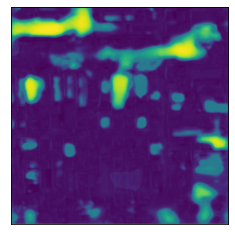

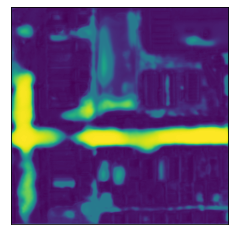

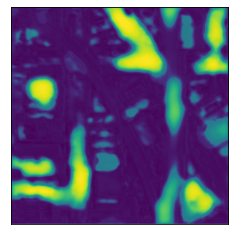

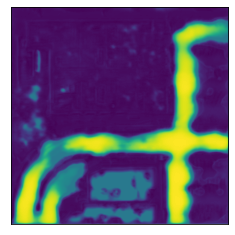

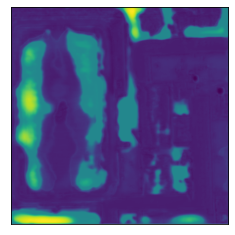

In [451]:
system.visualize_results()

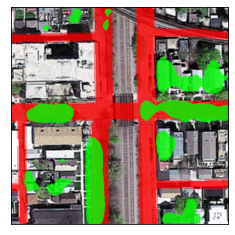

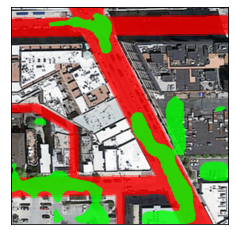

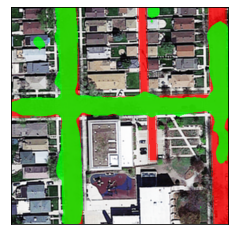

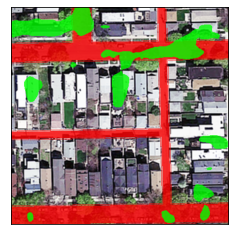

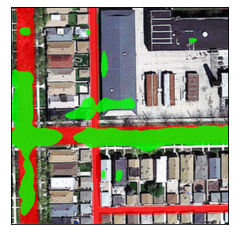

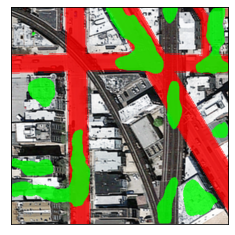

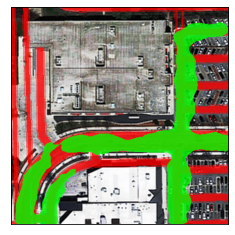

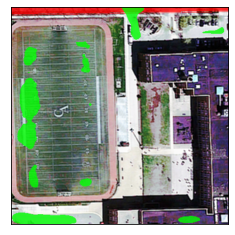

In [453]:
system.visualize_results_overlay()